In [1]:
import sys
sys.path.append('../')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from fb_gp import saas_fbgp
import numpy as np
import time
import jax.numpy as jnp
from jax import random,vmap, grad
from jax.lax import while_loop
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from acquisition import EI, IPV, optim_scipy_bh
import scipy.optimize
from scipy.stats import qmc
from jaxns import NestedSampler
import corner
from nested_sampler import nested_sampling_jaxns, nested_sampling_Dy
from getdist import plots,MCSamples,loadMCSamples


matplotlib.rc('font', size=16,family='serif')
matplotlib.rc('legend', fontsize=16)

### EI test

[[0.01795472 0.0032797  0.00629377 0.00188088]
 [0.0032797  0.01140048 0.00206096 0.00450058]
 [0.00629377 0.00206096 0.0193845  0.00201846]
 [0.00188088 0.00450058 0.00201846 0.01147207]]
(16, 4) (16, 1)
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:01<00:00, 795.97it/s, 7 steps of size 5.55e-01. acc. prob=0.90]



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]      1.90      1.90      1.29      0.13      4.05     32.18      0.97
_kernel_inv_length_sq[1]      1.61      2.28      1.08      0.07      3.75     25.42      1.02
_kernel_inv_length_sq[2]      0.81      0.54      0.67      0.20      1.48     39.42      0.97
_kernel_inv_length_sq[3]      9.26      8.12      6.64      2.26     20.10     37.39      0.97
        kernel_length[0]      1.46      0.61      1.24      0.84      2.35     30.71      1.00
        kernel_length[1]      1.80      0.91      1.53      0.66      2.55     31.92      1.02
        kernel_length[2]      2.05      0.95      1.74      0.88      3.72     25.33      0.98
        kernel_length[3]      0.62      0.19      0.62      0.33      0.93     31.57      0.98
            kernel_tausq      0.54      0.34      0.53      0.10      1.08     40.80      0.98
              kernel_var     11.34      7.56     

Text(0, 0.5, '$x_4$')

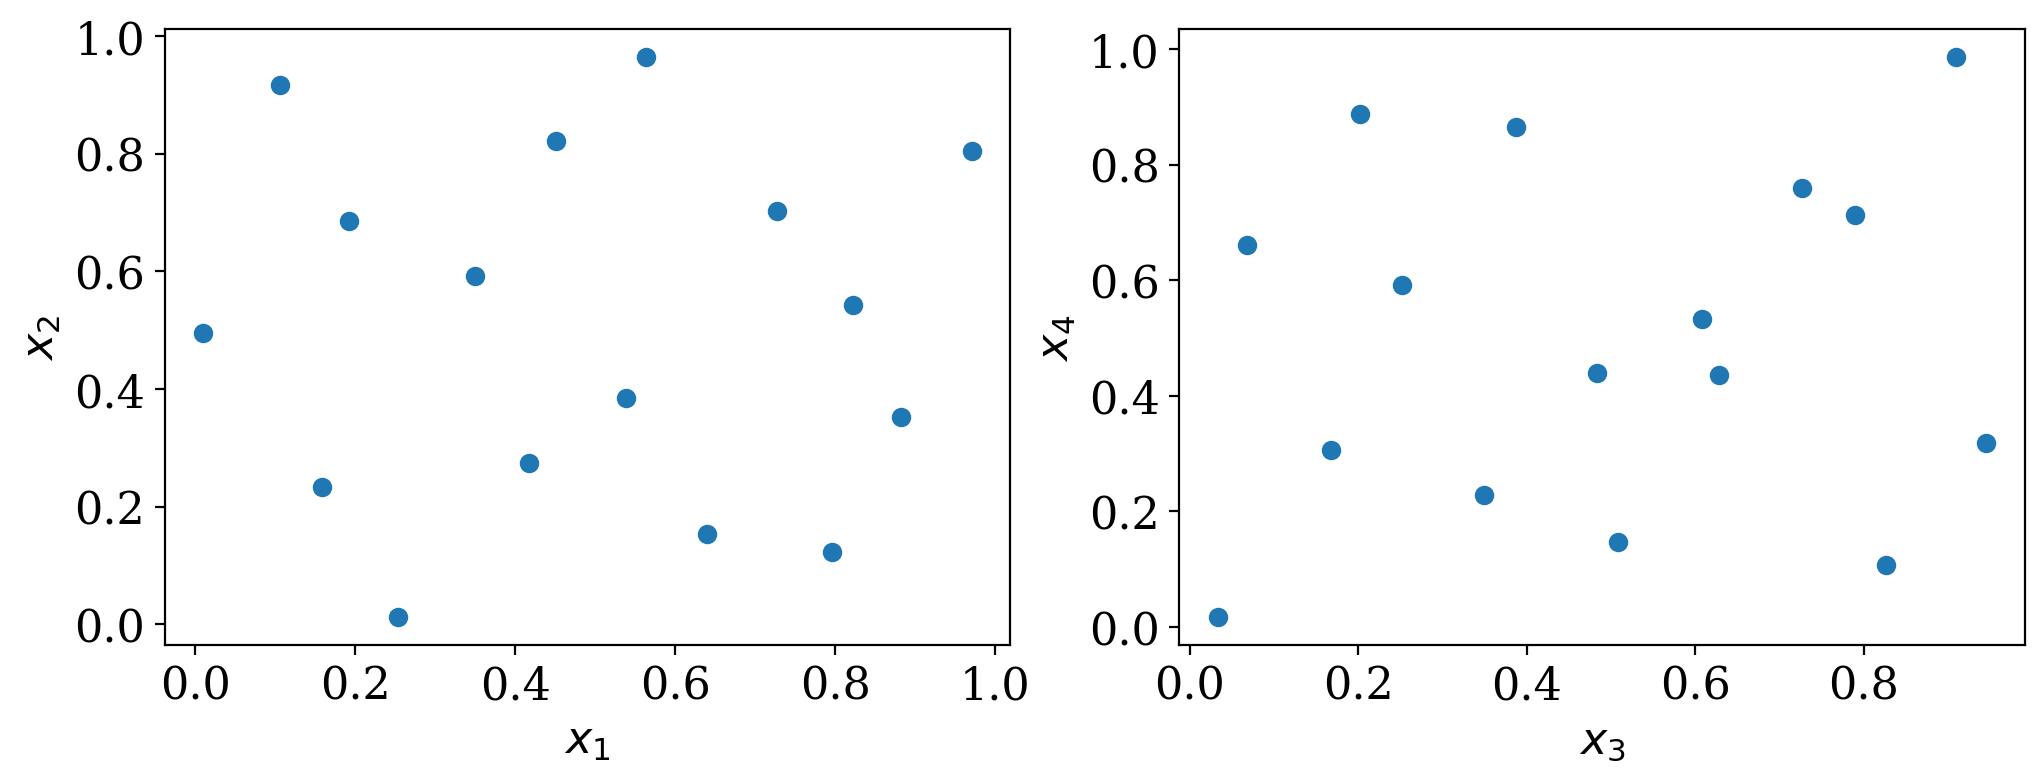

In [34]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 8
ndim = 4
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)
f_mean = np.array([0.41,0.63,0.58,0.45])[:ndim]
cov1 = 0.1*np.eye(ndim) + 0.2*np.random.uniform(0.,0.5,(ndim,ndim))
cov = 0.05*(cov1 + np.transpose(cov1))
print(cov)

from scipy.stats import multivariate_normal

mnorm =  multivariate_normal(mean = f_mean,cov = cov)

f = lambda x: mnorm.logpdf(x).reshape(-1,1) # -0.5*np.sum((x - f_mean)**2,axis=-1,keepdims=True)/ f_std**2 

train_y = f(train_x)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-6)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.scatter(train_x[:,0],train_x[:,1])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
ax2.scatter(train_x[:,2],train_x[:,3])
ax2.set_xlabel(r'$x_3$')
ax2.set_ylabel(r'$x_4$')

In [35]:
nsteps = 16 # 32
mc_points_size = 16
start = time.time()
for i in range(nsteps):
    samples, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    print(f"LogZ info :"+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
    size = len(samples)
    mc_points = samples[::int(size/mc_points_size),:]
    acq_func = EI(gp,gp.train_y.max()) # IPV(gp,mc_points)
    grad_fn = grad(acq_func)
    # print(ndim)
    x0 =  np.random.uniform(0,1,ndim)
    # print(x0.shape)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    # next_val = results.fun 
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x = jnp.atleast_2d(results.x)
    next_y = f((next_x)) 
    # print(next_y.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    gp = saas_fbgp(train_x,train_y,noise=1e-6)
    gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=False) # change rng key?
    print(f"----------------------Step {i+1} complete----------------------\n")


print(f"BO took {time.time() - start:.2f} s ")

Nested Sampling took 2.27s
jaxns made 18736 likelihood evaluations
LogZ info :logz_mean: = 6.2096, dlogz: = 0.2768, 
Acquisition optimization took 2.07 s
Next point at x = [0.28804268 1.         1.         0.48257998] with acquisition function value = -0.6336544833328174


sample: 100%|██████████| 512/512 [00:01<00:00, 461.06it/s, 15 steps of size 3.19e-01. acc. prob=0.88]



MCMC elapsed time: 1.50s
----------------------Step 1 complete----------------------

Nested Sampling took 2.31s
jaxns made 25549 likelihood evaluations
LogZ info :logz_mean: = 0.1691, dlogz: = 0.2520, 
Acquisition optimization took 1.62 s
Next point at x = [0.         0.51851951 0.         0.        ] with acquisition function value = -0.11745127477507428


sample: 100%|██████████| 512/512 [00:00<00:00, 514.84it/s, 7 steps of size 4.23e-01. acc. prob=0.92] 



MCMC elapsed time: 1.39s
----------------------Step 2 complete----------------------

Nested Sampling took 2.02s
jaxns made 29035 likelihood evaluations
LogZ info :logz_mean: = -0.0852, dlogz: = 0.2586, 
Acquisition optimization took 2.53 s
Next point at x = [0.         1.         0.14174349 0.37137596] with acquisition function value = -0.04103307134305165


sample: 100%|██████████| 512/512 [00:01<00:00, 450.77it/s, 15 steps of size 3.70e-01. acc. prob=0.91]



MCMC elapsed time: 1.53s
----------------------Step 3 complete----------------------

Nested Sampling took 3.47s
jaxns made 25746 likelihood evaluations
LogZ info :logz_mean: = 0.0572, dlogz: = 0.2645, 
Acquisition optimization took 2.57 s
Next point at x = [0.         0.67455551 1.         0.        ] with acquisition function value = -0.044081053854467686


sample: 100%|██████████| 512/512 [00:00<00:00, 541.03it/s, 15 steps of size 3.06e-01. acc. prob=0.84]



MCMC elapsed time: 1.29s
----------------------Step 4 complete----------------------

Nested Sampling took 2.24s
jaxns made 28914 likelihood evaluations
LogZ info :logz_mean: = -1.1242, dlogz: = 0.2634, 
Acquisition optimization took 2.77 s
Next point at x = [0.457001   0.63981297 0.5961555  0.45286964] with acquisition function value = -0.07551604721372468


sample: 100%|██████████| 512/512 [00:00<00:00, 551.57it/s, 7 steps of size 5.79e-01. acc. prob=0.89] 



MCMC elapsed time: 1.22s
----------------------Step 5 complete----------------------

Nested Sampling took 2.38s
jaxns made 30155 likelihood evaluations
LogZ info :logz_mean: = -0.1219, dlogz: = 0.2660, 
Acquisition optimization took 0.43 s
Next point at x = [0.72874796 0.71699825 0.16015943 0.92328712] with acquisition function value = -2.2918032385538583e-07


sample: 100%|██████████| 512/512 [00:00<00:00, 513.37it/s, 7 steps of size 6.13e-01. acc. prob=0.90] 



MCMC elapsed time: 1.21s
----------------------Step 6 complete----------------------

Nested Sampling took 2.23s
jaxns made 29879 likelihood evaluations
LogZ info :logz_mean: = -0.1496, dlogz: = 0.2637, 
Acquisition optimization took 0.39 s
Next point at x = [0.08114394 0.04208742 0.         0.3922578 ] with acquisition function value = -2.325663585546273e-09


sample: 100%|██████████| 512/512 [00:01<00:00, 481.07it/s, 7 steps of size 5.56e-01. acc. prob=0.89]



MCMC elapsed time: 1.27s
----------------------Step 7 complete----------------------

Nested Sampling took 2.27s
jaxns made 27530 likelihood evaluations
LogZ info :logz_mean: = -0.1247, dlogz: = 0.2619, 
Acquisition optimization took 0.49 s
Next point at x = [0.84530108 0.91917107 1.         0.46334718] with acquisition function value = -3.4416484269577815e-08


sample: 100%|██████████| 512/512 [00:01<00:00, 446.38it/s, 7 steps of size 7.46e-01. acc. prob=0.86]



MCMC elapsed time: 1.34s
----------------------Step 8 complete----------------------

Nested Sampling took 2.57s
jaxns made 29146 likelihood evaluations
LogZ info :logz_mean: = -0.0404, dlogz: = 0.2632, 
Acquisition optimization took 0.48 s
Next point at x = [0.96695637 0.         1.         0.57287308] with acquisition function value = -3.113830126194406e-12


sample: 100%|██████████| 512/512 [00:00<00:00, 531.40it/s, 7 steps of size 6.36e-01. acc. prob=0.91] 



MCMC elapsed time: 1.16s
----------------------Step 9 complete----------------------

Nested Sampling took 2.53s
jaxns made 29130 likelihood evaluations
LogZ info :logz_mean: = -0.0496, dlogz: = 0.2648, 
Acquisition optimization took 0.52 s
Next point at x = [0.50609901 0.64582961 0.5576946  0.58852273] with acquisition function value = -2.9013247650036533e-18


sample: 100%|██████████| 512/512 [00:01<00:00, 499.72it/s, 7 steps of size 6.58e-01. acc. prob=0.90]



MCMC elapsed time: 1.23s
----------------------Step 10 complete----------------------

Nested Sampling took 2.63s
jaxns made 29363 likelihood evaluations
LogZ info :logz_mean: = -0.2513, dlogz: = 0.2716, 
Acquisition optimization took 0.64 s
Next point at x = [0.77320814 1.         0.93405817 0.65812983] with acquisition function value = -2.7288459576987283e-19


sample: 100%|██████████| 512/512 [00:00<00:00, 529.80it/s, 7 steps of size 6.45e-01. acc. prob=0.92]



MCMC elapsed time: 1.17s
----------------------Step 11 complete----------------------

Nested Sampling took 2.34s
jaxns made 28871 likelihood evaluations
LogZ info :logz_mean: = -0.0387, dlogz: = 0.2636, 
Acquisition optimization took 0.40 s
Next point at x = [1.         0.59783401 0.93891275 1.        ] with acquisition function value = -1.0066623583133732e-09


sample: 100%|██████████| 512/512 [00:00<00:00, 571.52it/s, 7 steps of size 6.11e-01. acc. prob=0.92] 



MCMC elapsed time: 1.07s
----------------------Step 12 complete----------------------

Nested Sampling took 2.56s
jaxns made 29763 likelihood evaluations
LogZ info :logz_mean: = 0.0636, dlogz: = 0.2595, 
Acquisition optimization took 0.45 s
Next point at x = [0.3793844  0.17992983 0.23525416 0.        ] with acquisition function value = -2.8195972435286753e-19


sample: 100%|██████████| 512/512 [00:00<00:00, 551.06it/s, 7 steps of size 6.52e-01. acc. prob=0.89] 



MCMC elapsed time: 1.07s
----------------------Step 13 complete----------------------

Nested Sampling took 2.41s
jaxns made 25806 likelihood evaluations
LogZ info :logz_mean: = 0.1505, dlogz: = 0.2563, 
Acquisition optimization took 0.43 s
Next point at x = [0.0992287  0.56176474 0.97831873 0.57056694] with acquisition function value = -5.727603086810965e-26


sample: 100%|██████████| 512/512 [00:00<00:00, 535.71it/s, 7 steps of size 6.30e-01. acc. prob=0.89]



MCMC elapsed time: 1.08s
----------------------Step 14 complete----------------------

Nested Sampling took 2.37s
jaxns made 25617 likelihood evaluations
LogZ info :logz_mean: = 0.0944, dlogz: = 0.2578, 
Acquisition optimization took 0.42 s
Next point at x = [0.94275421 0.22215513 0.90207495 0.07422113] with acquisition function value = -1.0255860640444595e-55


sample: 100%|██████████| 512/512 [00:01<00:00, 490.31it/s, 7 steps of size 6.88e-01. acc. prob=0.89] 



MCMC elapsed time: 1.21s
----------------------Step 15 complete----------------------

Nested Sampling took 4.33s
jaxns made 26007 likelihood evaluations
LogZ info :logz_mean: = 0.1838, dlogz: = 0.2558, 
Acquisition optimization took 0.47 s
Next point at x = [0.         0.43136108 0.40253687 0.1158562 ] with acquisition function value = -2.698143100734944e-47


sample: 100%|██████████| 512/512 [00:01<00:00, 256.04it/s, 7 steps of size 6.62e-01. acc. prob=0.90] 



MCMC elapsed time: 2.22s
----------------------Step 16 complete----------------------

BO took 79.45 s 


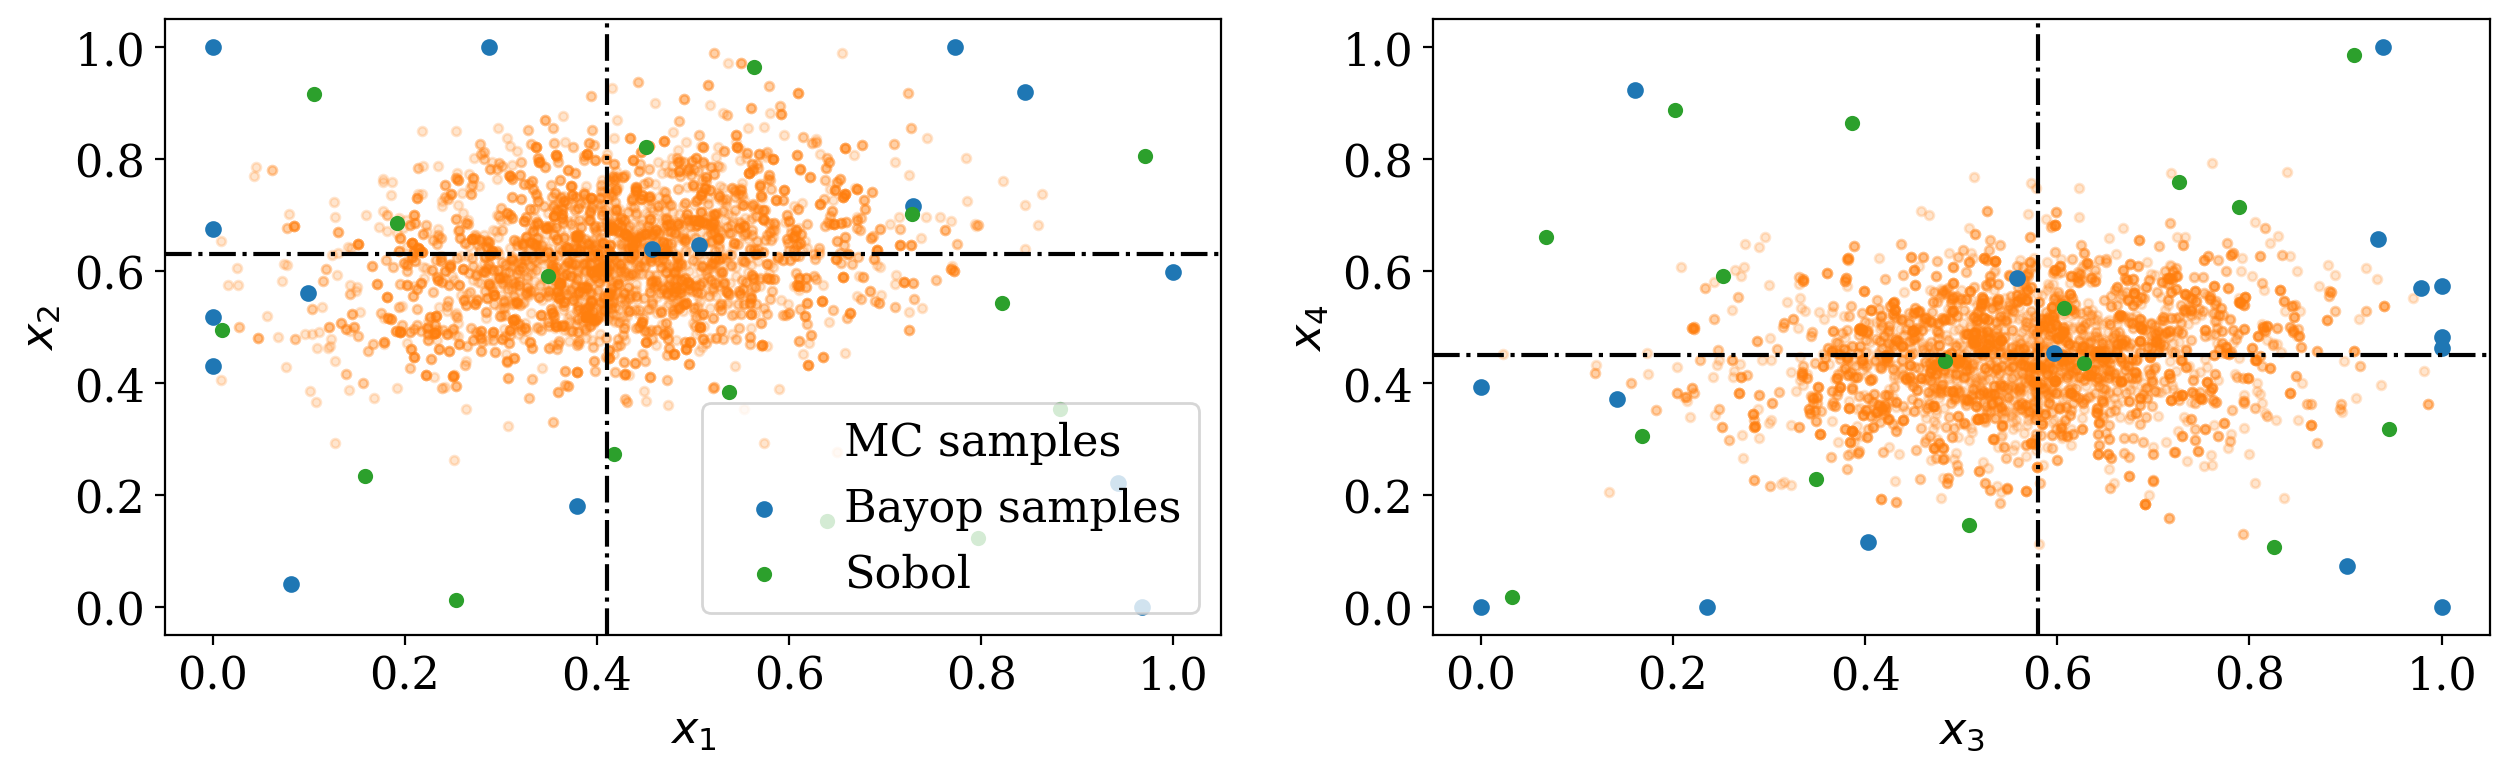

In [36]:
fig,ax = plt.subplots(1,int(ndim/2),figsize=(15,4))
for i,x in enumerate(ax):
    x.scatter(samples[:,2*i],samples[:,2*i+1],s=10,label='MC samples',color='C1',alpha=0.2)
    x.scatter(train_x[ninit:,2*i],train_x[ninit:,2*i+1],s=25,label='Bayop samples',color='C0')
    x.scatter(train_x[:ninit,2*i],train_x[:ninit,2*i+1],s=20,label='Sobol',color='C2')
    x.set_ylabel(r'$x_{{%i}}$'%(2*i+2))
    x.set_xlabel(r'$x_{{{}}}$'.format(2*i+1))
    x.axvline(f_mean[2*i],ls='-.',color='k')
    x.axhline(f_mean[2*i + 1],ls='-.',color='k')
ax[0].legend()

In [37]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.01,num_samples_equal=3000,difficult_model=True)
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

Nested Sampling took 5.84s
jaxns made 393405 likelihood evaluations
LogZ logz_mean: -0.0399, dlogz: 0.1470, 


Removed no burn in
Removed no burn in


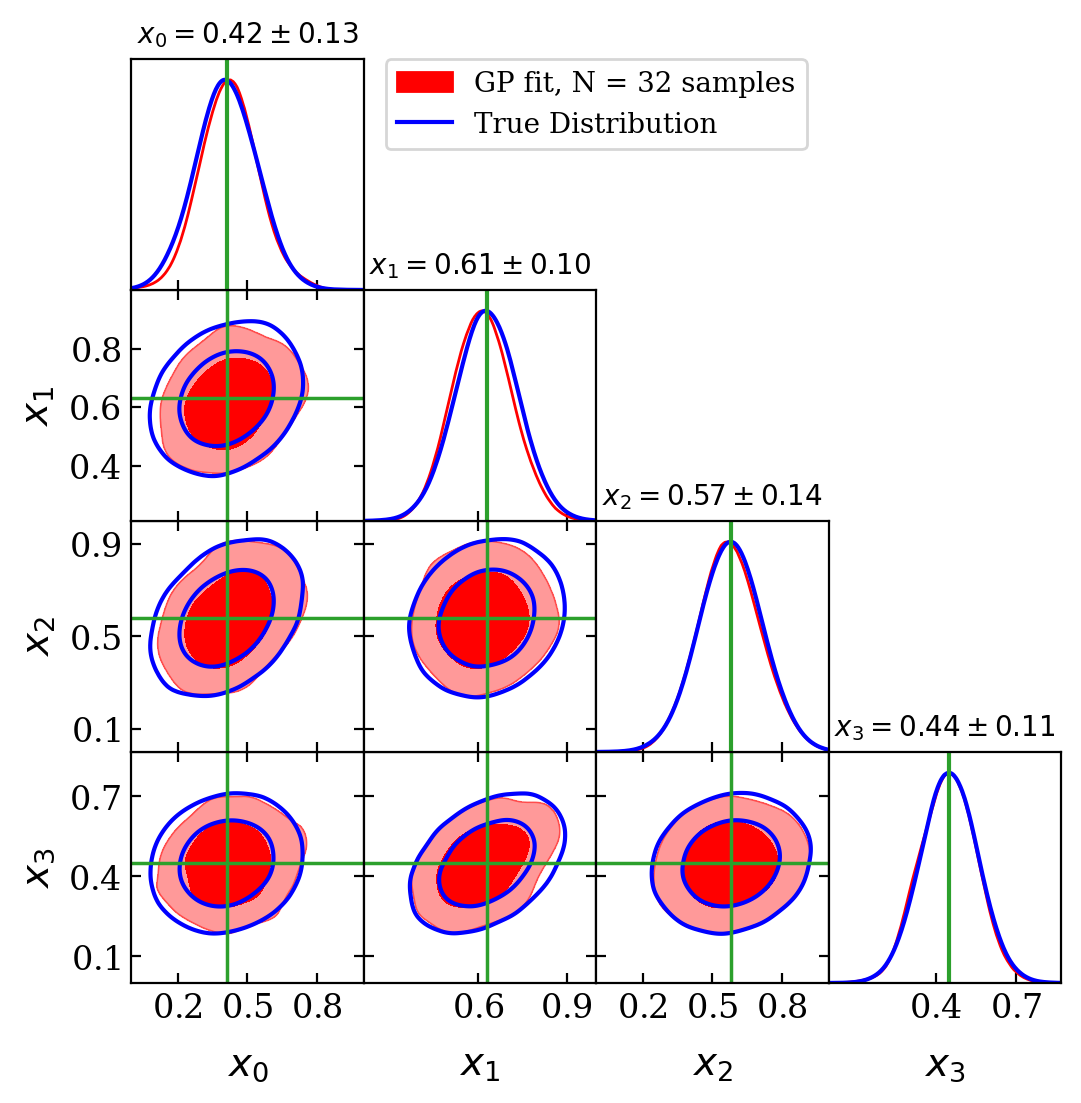

In [39]:
test_samples = np.random.multivariate_normal(mean=f_mean,cov=cov,size=int(1e5))
labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  np.array(ndim*[[0,1]])
true_samples = MCSamples(samples=test_samples,names=names, labels = labels,ranges=ranges) # a comparison run
gp_samples = MCSamples(samples=samples[::4],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=1.5,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 14
g.settings.title_limit_fontsize = 14
g.triangle_plot([gp_samples,true_samples], names,filled=[True,False],contour_colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} samples','True Distribution'],
                                contour_lws=[1,1.5],markers = dict(zip(names,f_mean)),
                                marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'},title_limit=1 ) # type: ignore

for i in range(ndim):
    ax = g.subplots[i,i]
    ax.axvline(f_mean[i], color='C2', ls='-')




### IPV test

[[0.01795472 0.0032797  0.00629377 0.00188088]
 [0.0032797  0.01140048 0.00206096 0.00450058]
 [0.00629377 0.00206096 0.0193845  0.00201846]
 [0.00188088 0.00450058 0.00201846 0.01147207]]
(16, 4) (16, 1)
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:00<00:00, 1371.91it/s, 15 steps of size 4.12e-01. acc. prob=0.88]
INFO:[GP]: MCMC elapsed time: 1.85s



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]      1.79      3.03      0.54      0.02      4.22     37.80      0.97
_kernel_inv_length_sq[1]      7.11     12.34      3.73      0.33     13.18     36.97      0.97
_kernel_inv_length_sq[2]      1.33      1.40      0.93      0.09      2.92     60.40      0.97
_kernel_inv_length_sq[3]      2.66      1.75      2.30      0.46      4.36     61.77      1.01
        kernel_length[0]      1.91      1.42      1.47      0.28      4.13     32.88      0.98
        kernel_length[1]      0.66      0.25      0.65      0.19      1.01     26.71      0.97
        kernel_length[2]      1.50      0.95      1.21      0.63      3.28     51.59      1.00
        kernel_length[3]      0.86      0.36      0.84      0.36      1.20     39.30      0.99
            kernel_tausq      1.13      1.20      0.61      0.14      2.41     44.55      0.98
              kernel_var     10.30      6.65     

Text(0, 0.5, '$x_4$')

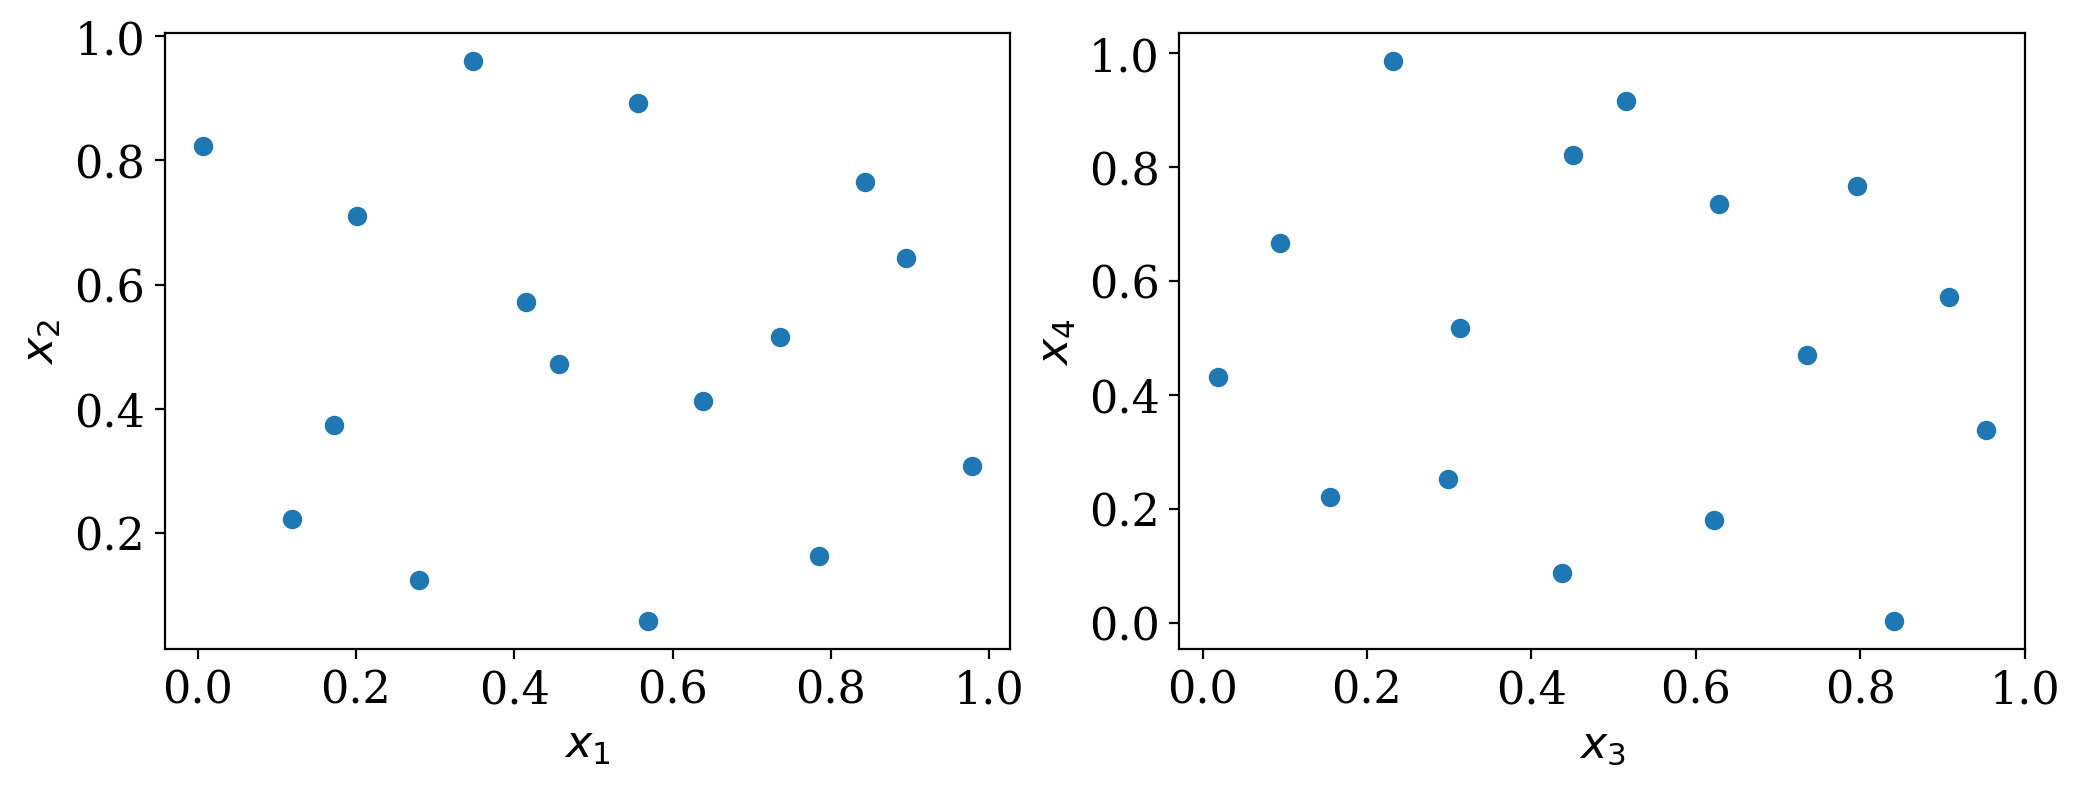

In [2]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 16
ndim = 4
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)
f_mean = np.array([0.41,0.63,0.58,0.45])[:ndim]
cov1 = 0.1*np.eye(ndim) + 0.2*np.random.uniform(0.,0.5,(ndim,ndim))
cov = 0.05*(cov1 + np.transpose(cov1))
print(cov)

from scipy.stats import multivariate_normal

mnorm =  multivariate_normal(mean = f_mean,cov = cov)

f = lambda x: mnorm.logpdf(x).reshape(-1,1) # -0.5*np.sum((x - f_mean)**2,axis=-1,keepdims=True)/ f_std**2 

train_y = f(train_x)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-6)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.scatter(train_x[:,0],train_x[:,1])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
ax2.scatter(train_x[:,2],train_x[:,3])
ax2.set_xlabel(r'$x_3$')
ax2.set_ylabel(r'$x_4$')

In [3]:
nsteps = 16 # 32
mc_points_size = 16
start = time.time()
for i in range(nsteps):
    samples, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    print(f"LogZ info :"+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
    size = len(samples)
    mc_points = samples[::int(size/mc_points_size),:]
    # print(mc_points.shape)
    acq_func = IPV(gp,mc_points)
    grad_fn = grad(acq_func)
    # print(ndim)
    x0 =  np.random.uniform(0,1,ndim)
    # print(x0.shape)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    # next_val = results.fun 
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x = jnp.atleast_2d(results.x)
    next_y = f((next_x)) 
    # print(next_y.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    seed = i
    rng_key, _ = random.split(random.PRNGKey(seed), 2)
    gp.update(next_x,next_y,rng_key)
    # gp = saas_fbgp(train_x,train_y,noise=1e-6)
    # gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=False) # change rng key?
    print(f"----------------------Step {i+1} complete----------------------\n")


print(f"BO took {time.time() - start:.2f} s ")

INFO:[NS]: Nested Sampling took 2.65s
INFO:[NS]: jaxns did 22690 likelihood evaluations


LogZ info :logz_mean: = 0.6238, dlogz: = 0.2679, 


INFO:[AQ]: Acquisition optimization took 1.63 s


Next point at x = [0.04045978 0.44685801 0.56192864 0.24332202] with acquisition function value = 0.02355423613022361


sample: 100%|██████████| 384/384 [00:00<00:00, 721.22it/s, 7 steps of size 4.66e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 0.86s


----------------------Step 1 complete----------------------



INFO:[NS]: Nested Sampling took 1.74s
INFO:[NS]: jaxns did 22666 likelihood evaluations


LogZ info :logz_mean: = -2.1806, dlogz: = 0.2440, 


INFO:[AQ]: Acquisition optimization took 1.99 s


Next point at x = [0.12968995 0.33376887 0.13207966 0.24316334] with acquisition function value = 0.021836869833234462


sample: 100%|██████████| 384/384 [00:00<00:00, 731.81it/s, 7 steps of size 4.72e-01. acc. prob=0.85]
INFO:[GP]: MCMC elapsed time: 0.80s


----------------------Step 2 complete----------------------



INFO:[NS]: Nested Sampling took 1.75s
INFO:[NS]: jaxns did 18603 likelihood evaluations


LogZ info :logz_mean: = -2.2952, dlogz: = 0.2419, 


INFO:[AQ]: Acquisition optimization took 1.71 s


Next point at x = [0.26069978 0.67565176 0.69330661 0.47193887] with acquisition function value = 0.029172781701248277


sample: 100%|██████████| 384/384 [00:00<00:00, 713.28it/s, 7 steps of size 4.39e-01. acc. prob=0.95]
INFO:[GP]: MCMC elapsed time: 0.81s


----------------------Step 3 complete----------------------



INFO:[NS]: Nested Sampling took 1.91s
INFO:[NS]: jaxns did 26839 likelihood evaluations


LogZ info :logz_mean: = -1.0352, dlogz: = 0.2533, 


INFO:[AQ]: Acquisition optimization took 2.36 s


Next point at x = [0.35652083 0.68153911 0.5680136  0.43607769] with acquisition function value = 0.005701816338742256


sample: 100%|██████████| 384/384 [00:00<00:00, 708.52it/s, 7 steps of size 5.12e-01. acc. prob=0.89]
INFO:[GP]: MCMC elapsed time: 0.83s


----------------------Step 4 complete----------------------



INFO:[NS]: Nested Sampling took 1.50s
INFO:[NS]: jaxns did 28689 likelihood evaluations


LogZ info :logz_mean: = -0.0621, dlogz: = 0.2586, 


INFO:[AQ]: Acquisition optimization took 2.35 s


Next point at x = [0.43115928 0.59522319 0.58473243 0.4054754 ] with acquisition function value = 0.0015637800555370202


sample: 100%|██████████| 384/384 [00:00<00:00, 730.93it/s, 7 steps of size 5.68e-01. acc. prob=0.91]
INFO:[GP]: MCMC elapsed time: 0.81s


----------------------Step 5 complete----------------------



INFO:[NS]: Nested Sampling took 1.51s
INFO:[NS]: jaxns did 28797 likelihood evaluations


LogZ info :logz_mean: = -0.0512, dlogz: = 0.2573, 


INFO:[AQ]: Acquisition optimization took 2.29 s


Next point at x = [0.39955923 0.74328419 0.56734365 0.54026181] with acquisition function value = 0.0008537895711955099


sample: 100%|██████████| 384/384 [00:00<00:00, 675.88it/s, 7 steps of size 6.37e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 0.86s


----------------------Step 6 complete----------------------



INFO:[NS]: Nested Sampling took 1.58s
INFO:[NS]: jaxns did 28619 likelihood evaluations


LogZ info :logz_mean: = 0.0439, dlogz: = 0.2585, 


INFO:[AQ]: Acquisition optimization took 1.96 s


Next point at x = [0.6521052  0.58640055 0.56020955 0.33902699] with acquisition function value = 0.0007887730891489725


sample: 100%|██████████| 384/384 [00:00<00:00, 698.76it/s, 7 steps of size 7.25e-01. acc. prob=0.86]
INFO:[GP]: MCMC elapsed time: 0.85s


----------------------Step 7 complete----------------------



INFO:[NS]: Nested Sampling took 1.55s
INFO:[NS]: jaxns did 28404 likelihood evaluations


LogZ info :logz_mean: = 0.0585, dlogz: = 0.2574, 


INFO:[AQ]: Acquisition optimization took 2.09 s


Next point at x = [0.36313548 0.63063718 0.44969255 0.5056937 ] with acquisition function value = 0.0002195198385124969


sample: 100%|██████████| 384/384 [00:00<00:00, 700.42it/s, 7 steps of size 7.05e-01. acc. prob=0.92]
INFO:[GP]: MCMC elapsed time: 0.84s


----------------------Step 8 complete----------------------



INFO:[NS]: Nested Sampling took 1.82s
INFO:[NS]: jaxns did 28981 likelihood evaluations


LogZ info :logz_mean: = 0.0218, dlogz: = 0.2574, 


INFO:[AQ]: Acquisition optimization took 2.73 s


Next point at x = [0.4252668  0.82195097 0.51902219 0.53206079] with acquisition function value = 0.00033818197188916627


sample: 100%|██████████| 384/384 [00:00<00:00, 686.96it/s, 7 steps of size 6.27e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 0.86s


----------------------Step 9 complete----------------------



INFO:[NS]: Nested Sampling took 1.58s
INFO:[NS]: jaxns did 29352 likelihood evaluations


LogZ info :logz_mean: = 0.0143, dlogz: = 0.2607, 


INFO:[AQ]: Acquisition optimization took 1.26 s


Next point at x = [0.33447123 0.57777948 0.24328844 0.40552703] with acquisition function value = 8.137755592768636e-05


sample: 100%|██████████| 384/384 [00:00<00:00, 656.09it/s, 7 steps of size 6.23e-01. acc. prob=0.92]
INFO:[GP]: MCMC elapsed time: 0.90s


----------------------Step 10 complete----------------------



INFO:[NS]: Nested Sampling took 1.59s
INFO:[NS]: jaxns did 25492 likelihood evaluations


LogZ info :logz_mean: = 0.0832, dlogz: = 0.2631, 


INFO:[AQ]: Acquisition optimization took 2.09 s


Next point at x = [0.48716058 0.90208971 0.80166212 0.44540927] with acquisition function value = 0.00011051919619012307


sample: 100%|██████████| 384/384 [00:00<00:00, 664.81it/s, 7 steps of size 5.74e-01. acc. prob=0.93] 
INFO:[GP]: MCMC elapsed time: 0.92s


----------------------Step 11 complete----------------------



INFO:[NS]: Nested Sampling took 1.62s
INFO:[NS]: jaxns did 29116 likelihood evaluations


LogZ info :logz_mean: = -0.0024, dlogz: = 0.2632, 


INFO:[AQ]: Acquisition optimization took 1.47 s


Next point at x = [1.         0.60377686 0.41122601 0.94588307] with acquisition function value = 5.176935673106148e-05


sample: 100%|██████████| 384/384 [00:00<00:00, 630.83it/s, 7 steps of size 7.04e-01. acc. prob=0.91]
INFO:[GP]: MCMC elapsed time: 0.95s


----------------------Step 12 complete----------------------



INFO:[NS]: Nested Sampling took 1.66s
INFO:[NS]: jaxns did 25301 likelihood evaluations


LogZ info :logz_mean: = 0.1383, dlogz: = 0.2606, 


INFO:[AQ]: Acquisition optimization took 1.46 s


Next point at x = [0.01163939 0.41374332 0.58089461 0.19508881] with acquisition function value = 5.611614318094815e-05


sample: 100%|██████████| 384/384 [00:00<00:00, 652.84it/s, 7 steps of size 5.51e-01. acc. prob=0.94] 
INFO:[GP]: MCMC elapsed time: 0.92s


----------------------Step 13 complete----------------------



INFO:[NS]: Nested Sampling took 1.64s
INFO:[NS]: jaxns did 25968 likelihood evaluations


LogZ info :logz_mean: = 0.1201, dlogz: = 0.2620, 


INFO:[AQ]: Acquisition optimization took 1.07 s


Next point at x = [0.17014853 0.39285631 0.85173845 0.78112256] with acquisition function value = 3.6887586446446297e-05


sample: 100%|██████████| 384/384 [00:00<00:00, 676.41it/s, 7 steps of size 6.30e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 0.89s


----------------------Step 14 complete----------------------



INFO:[NS]: Nested Sampling took 1.67s
INFO:[NS]: jaxns did 28656 likelihood evaluations


LogZ info :logz_mean: = -0.0080, dlogz: = 0.2647, 


INFO:[AQ]: Acquisition optimization took 1.04 s


Next point at x = [0.8560562  0.06648327 0.80122971 0.20202888] with acquisition function value = 2.8498827501971524e-05


sample: 100%|██████████| 384/384 [00:00<00:00, 649.31it/s, 7 steps of size 6.00e-01. acc. prob=0.93]
INFO:[GP]: MCMC elapsed time: 0.94s


----------------------Step 15 complete----------------------



INFO:[NS]: Nested Sampling took 1.79s
INFO:[NS]: jaxns did 28595 likelihood evaluations


LogZ info :logz_mean: = -0.1601, dlogz: = 0.2686, 


INFO:[AQ]: Acquisition optimization took 0.74 s


Next point at x = [0.03081522 0.75463651 0.5533812  0.58626911] with acquisition function value = 3.553465244006404e-05


sample: 100%|██████████| 384/384 [00:00<00:00, 398.73it/s, 3 steps of size 6.93e-01. acc. prob=0.91]
INFO:[GP]: MCMC elapsed time: 1.32s


----------------------Step 16 complete----------------------

BO took 75.98 s 


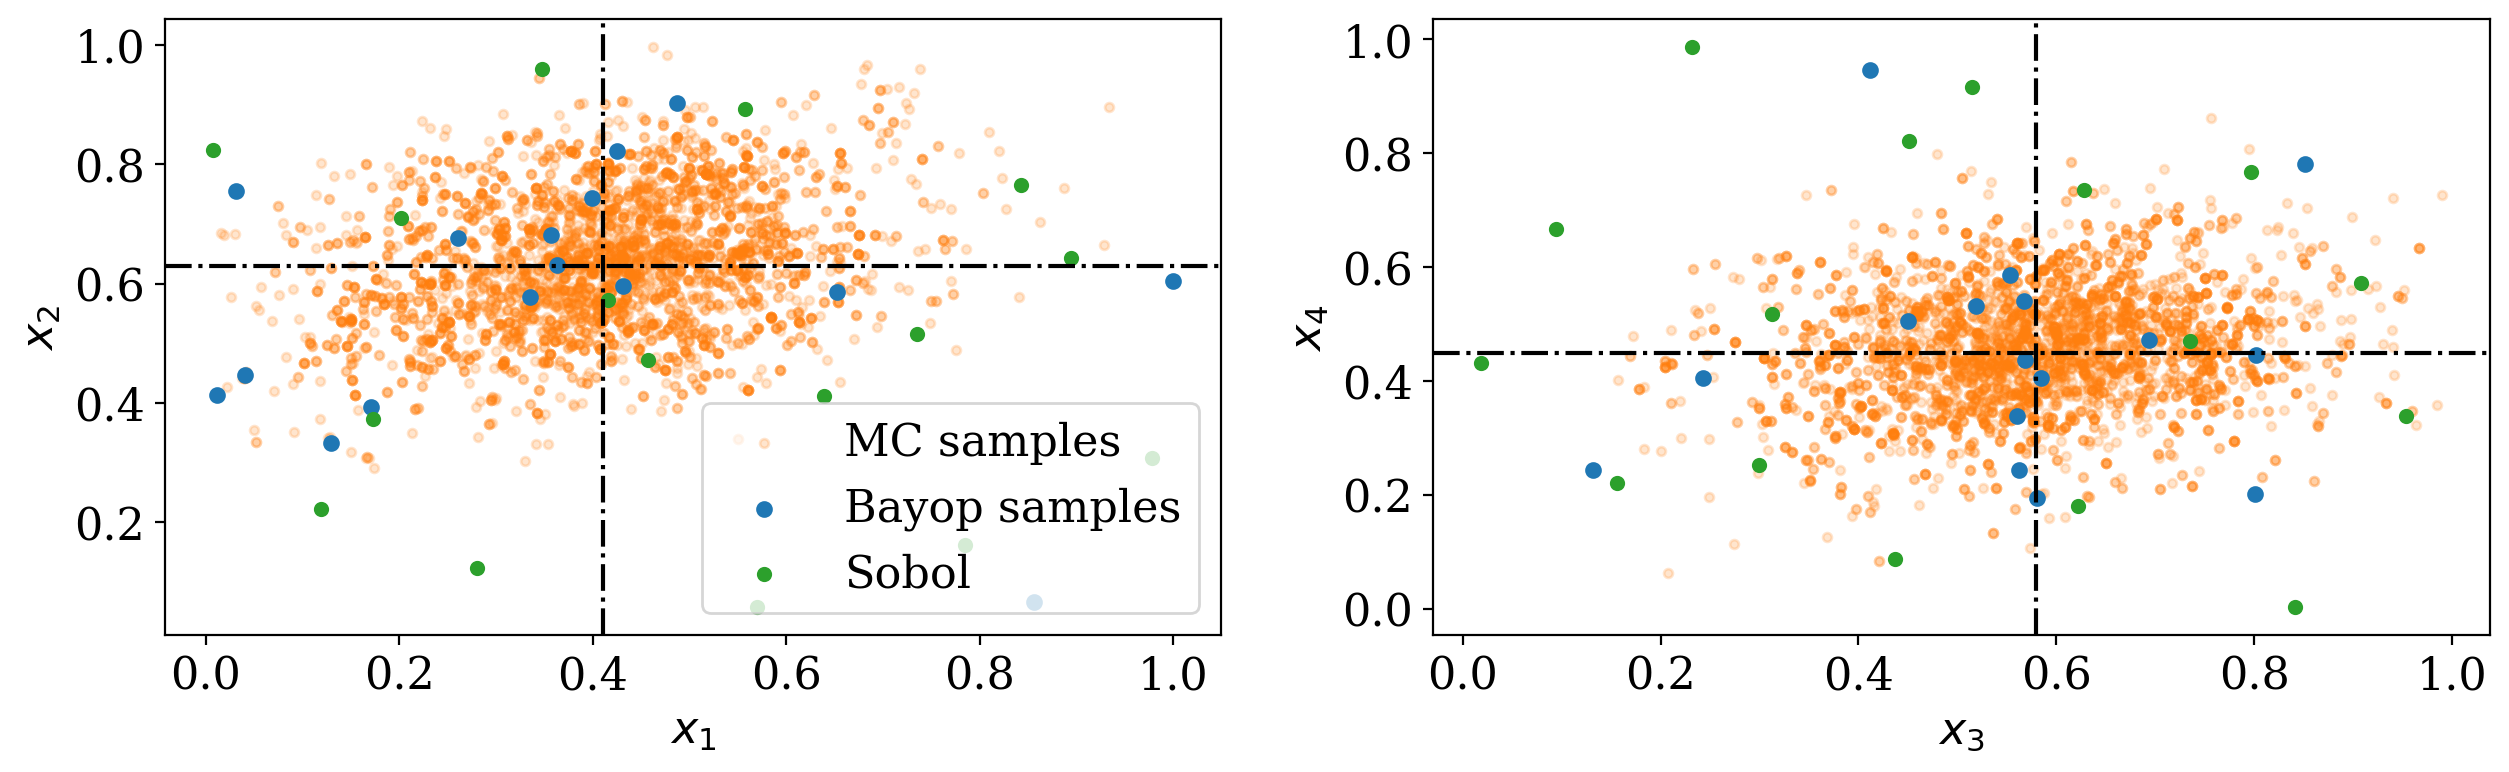

In [4]:
fig,ax = plt.subplots(1,int(ndim/2),figsize=(15,4))
for i,x in enumerate(ax):
    x.scatter(samples[:,2*i],samples[:,2*i+1],s=10,label='MC samples',color='C1',alpha=0.2)
    x.scatter(train_x[ninit:,2*i],train_x[ninit:,2*i+1],s=25,label='Bayop samples',color='C0')
    x.scatter(train_x[:ninit,2*i],train_x[:ninit,2*i+1],s=20,label='Sobol',color='C2')
    x.set_ylabel(r'$x_{{%i}}$'%(2*i+2))
    x.set_xlabel(r'$x_{{{}}}$'.format(2*i+1))
    x.axvline(f_mean[2*i],ls='-.',color='k')
    x.axhline(f_mean[2*i + 1],ls='-.',color='k')
ax[0].legend()

In [5]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.01,num_samples_equal=3000,difficult_model=True)
print(f"LogZ info: "+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))

INFO:[NS]: Nested Sampling took 4.90s
INFO:[NS]: jaxns did 383315 likelihood evaluations


LogZ info: logz_mean: = 0.0324, dlogz: = 0.1460, 


Removed no burn in
Removed no burn in


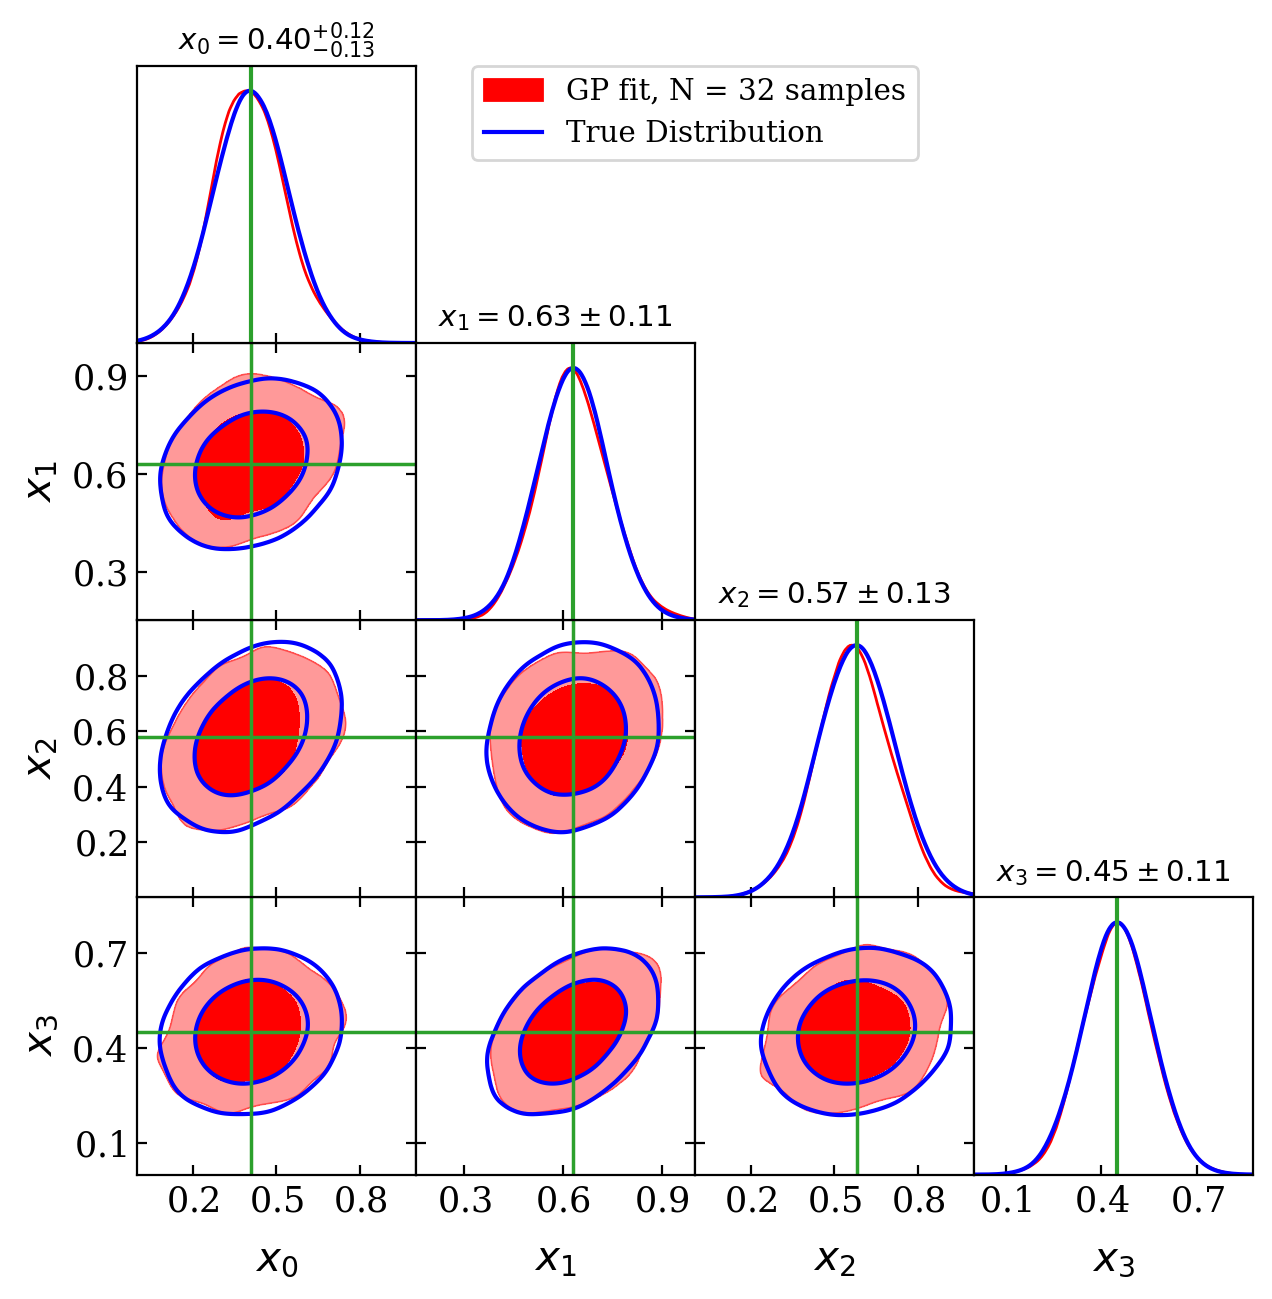

In [6]:
test_samples = np.random.multivariate_normal(mean=f_mean,cov=cov,size=int(1e5))
labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  np.array(ndim*[[0,1]])
true_samples = MCSamples(samples=test_samples,names=names, labels = labels,ranges=ranges) # a comparison run
gp_samples = MCSamples(samples=samples[::4],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=1.8,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 14
g.settings.title_limit_fontsize = 14
g.triangle_plot([gp_samples,true_samples], names,filled=[True,False],contour_colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} samples','True Distribution'],
                                contour_lws=[1,1.5],markers = dict(zip(names,f_mean)),
                                marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'},title_limit=1 ) # type: ignore

for i in range(ndim):
    ax = g.subplots[i,i]
    ax.axvline(f_mean[i], color='C2', ls='-')

# for ax in g.subplots[:,0]:
#     ax.axvline(, color='C2', ls='-')
# IPython.display.display(g.fig)

